# Homework 7: Decision Trees, Bagging, Random Forests
Part1 Decision Tree questions

Part2 Application to the real data

Part 3 Multiclass metrics

## Part 1 (3 pt) Basic elements of decision trees
**Write the code line that calculates the result.**

---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_34674/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


**Q 1 (1 pt)** Given that 10 objects have reached a decision tree node, where 8 of them belong to class $C_1$, and 2 belong to class $C_2,$ calculate the impurity of this node, using entropy.

In [3]:
c1 = 8 / 10
c2 = 2 / 10
entropy = -c1 * np.log2(c1) - c2 * np.log2(c2)
print( entropy)

0.7219280948873623


**Q2 (1 pt)** Additionally, it is known that the node from the previous task is not a leaf, and it is possible to split it in such a way that all objects of class $C_1$ end up in the left subtree and class $C_2$ objects end up in the right subtree. Calculate the (non-truncated) information gain criterion:

$$
Q = H(V) - \frac{|V_L|}{|V|}H(V_L) - \frac{|V_R|}{|V|}H(V_R).
$$
Now, $H(V)$ is calculated using Gini index:
$$
H(V) = \sum_{k=1}^C p_k(1-p_k),
$$
where $C$ is the number of classes (two in our case).

In [4]:
gini = 1 - c1**2 - c2**2
gini_left = 0 
gini_right = 0
q = gini - (8/10) * gini_left - (2/10) * gini_right
print(q)

0.31999999999999984


**Q3 (1 pt)** During the tree construction using MAE metric for impurity (a regression problem is being solved), a leaf node is formed with 10 objects, and the values of the target variable for these objects are as follows: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]. What will be the model's predictions for these objects?

In [5]:
target_values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
prediction = np.median(target_values)
print(prediction)

38.5


## Part 2: (12 pt) Bagging and Random Forest
We well work with the dataset from HW6. Just run all the cells below to cteate data for training and evaluation.

---

In [10]:
#m=pd.read_csv(path+'Members.csv',index_col='MemberID')
m=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Members.csv',index_col='MemberID')

In [11]:
m.head()

,AgeAtFirstClaim,Sex
MemberID,,
14723353,70-79,M
75706636,70-79,M
17320609,70-79,M
69690888,40-49,M
33004608,0-9,M


In [15]:
#claims=pd.read_csv(path+'Claims_Y1.csv',index_col='MemberID')
claims=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Claims.csv',index_col='MemberID')

In [16]:
claims.head()

,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
MemberID,,,,,,,,,,,,,
42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0
2759427,2997752.0,140343.0,91972.0,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0
73570559,7053364.0,240043.0,70119.0,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0
11837054,7557061.0,496247.0,68968.0,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0


In [13]:
#days2=pd.read_csv(path+'DaysInHospital_Y2.csv',index_col='MemberID')
days2=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/DaysInHospital_Y2.csv',index_col='MemberID')

In [14]:
days2.head()

,ClaimsTruncated,DaysInHospital
MemberID,,
24027423,0,0
98324177,0,0
33899367,1,1
5481382,0,1
69908334,0,0


In [17]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s.split('-')[0]) if s!='80+' else 80)

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

/tmp/ipykernel_34674/3634060461.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)


In [18]:
f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max()
f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum()

In [19]:
y = (days2['DaysInHospital']>0).astype('int').values
X = days2[['ClaimsTruncated']]
X = X.join(f_Charlson)
X = X.join(f_LengthOfStay)
X = X.join(m.AgeAtFirstClaim)

In [20]:
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim
MemberID,,,,
24027423,0,3,0,30
98324177,0,0,0,30
33899367,1,0,0,80
5481382,0,0,1,20
69908334,0,1,0,60


In [21]:
X = X.join(m.Sex)

In [22]:
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex
MemberID,,,,,
24027423,0,3,0,30,M
98324177,0,0,0,30,M
33899367,1,0,0,80,F
5481382,0,0,1,20,F
69908334,0,1,0,60,F


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [26]:
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['Sex'])], remainder='passthrough')

In [27]:
transform.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='infrequent_if_exist'),
                                 ['Sex'])])

In [28]:
X_train_transformed = pd.DataFrame(transform.transform(X_train),columns=transform.get_feature_names_out())
X_train_transformed.head()

,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,1.0,0.0,0.0,1.0,0.0,50.0
1,0.0,0.0,0.0,0.0,0.0,20.0
2,0.0,0.0,0.0,0.0,0.0,70.0
3,0.0,1.0,0.0,0.0,0.0,50.0
4,1.0,0.0,0.0,1.0,0.0,70.0


In [29]:
X_test_transformed = pd.DataFrame(transform.transform(X_test),columns=transform.get_feature_names_out())
X_test_transformed.head()

,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,0.0,0.0,0.0,0.0,3.0,30.0
1,0.0,0.0,1.0,1.0,1.0,80.0
2,1.0,0.0,0.0,0.0,0.0,40.0
3,0.0,0.0,0.0,0.0,0.0,60.0
4,0.0,0.0,0.0,1.0,0.0,80.0


In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split

**Q4 (4 pt)** On the training set, find the optimal values for the hyperparameters `max_depth` and `min_samples_leaf` for the `DecisionTreeClassifier`. To do this:

(a) Create a dictionary with possible values to iterate over.

(b) Use grid search with cross-validation (we don't use validation set) using the F1-score as the criterion (parameter `scoring` in GridSearchCV).

(c) Choose the pair of values that provides the best quality.

Train the decision tree with the selected hyperparameters on the full training set. Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.

In [31]:
from sklearn.model_selection import GridSearchCV

In [34]:
#a
param_grid = {
    'max_depth': range(1, 15),
    'min_samples_leaf': range(1, 25)
}

In [35]:
#b
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 15),
                         'min_samples_leaf': range(1, 25)},
             scoring='f1')

In [37]:
#c
best_params = grid_search.best_params_
print(best_params)

{'max_depth': 8, 'min_samples_leaf': 20}


In [38]:
best_tree = DecisionTreeClassifier(max_depth = best_params['max_depth'], min_samples_leaf = best_params['min_samples_leaf'])
best_tree.fit(X_train_transformed, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=20)

In [39]:
y_pred = best_tree.predict(X_test_transformed)

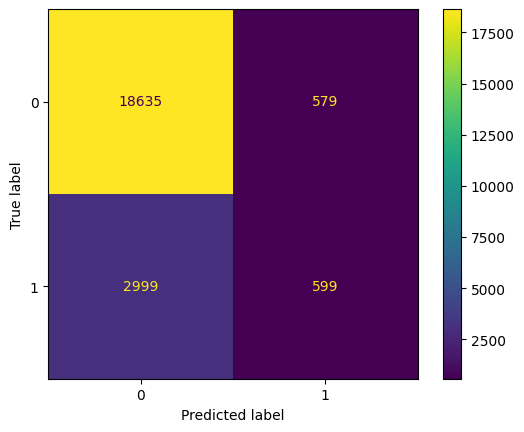

In [41]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [42]:
recall_score(y_test, y_pred)

0.16648137854363534

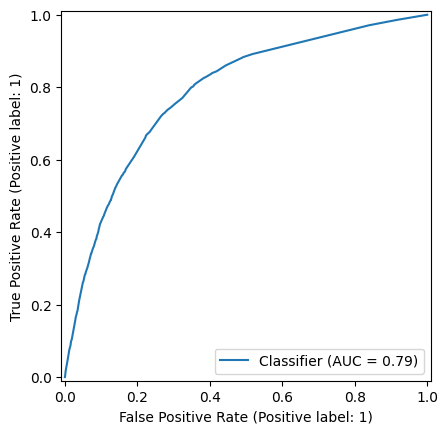

In [43]:
RocCurveDisplay.from_predictions(y_test, best_tree.predict_proba(X_test_transformed)[:,1])

**Q5 (3 pt)** Train [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with 50 trees on the training set, use parameter `max_samples=0.9`. Estimate the quality using metrics from the previous question.

In [44]:
clf_bag = BaggingClassifier(n_estimators=50, max_samples=0.9)
clf_bag.fit(X_train_transformed, y_train)

BaggingClassifier(max_samples=0.9, n_estimators=50)

In [45]:
y_pred_bag = clf_bag.predict(X_test_transformed)

In [46]:
recall_score(y_test, y_pred_bag)

0.1481378543635353

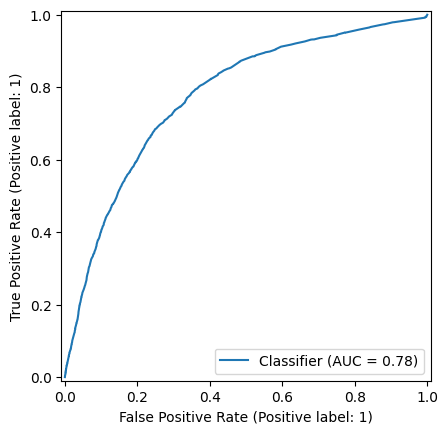

In [47]:
RocCurveDisplay.from_predictions(y_test, clf_bag.predict_proba(X_test_transformed)[:,1])

**Q6 (4 pt)** On the training set, find the optimal values for the hyperparameters `max_depth` and `min_samples_split` for the `Random Forest`. To do this:

(a) Create a dictionary with possible values to iterate over.

(b) Use grid search with cross-validation (we don't use validation set) using the f1-score as the criterion (parameter `scoring="f1"` in GridSearchCV).

(c) Choose the pair of values that provides the best quality.

Train the random forest with the selected hyperparameters on the full training set. Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.

Which of these models worked better?

In [48]:
clf_rf = RandomForestClassifier(class_weight='balanced')

In [49]:
clf_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [50]:
param_grid = {
    'max_depth': [5, 7, 10, 12, 15],
    'min_samples_split': [5, 7, 10, 12, 15, 17, 20]
}

In [51]:
grid_search = GridSearchCV(clf_rf, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [5, 7, 10, 12, 15],
                         'min_samples_split': [5, 7, 10, 12, 15, 17, 20]},
             scoring='f1')

In [52]:
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

Best parameters:  {'max_depth': 10, 'min_samples_split': 20}


In [53]:
best_clf_rf = RandomForestClassifier(class_weight='balanced', max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'])
best_clf_rf.fit(X_train_transformed, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=20)

In [54]:
y_pred_rf = best_clf_rf.predict(X_test_transformed)

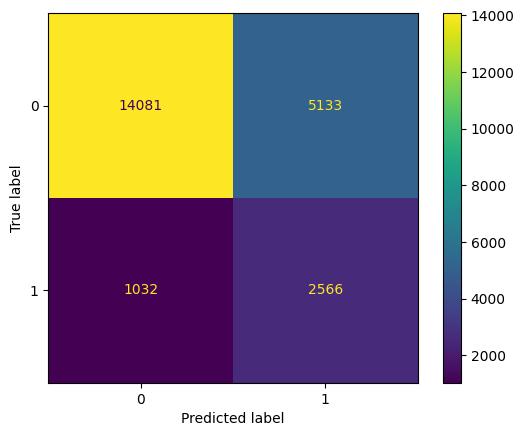

In [55]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)

In [56]:
recall_score(y_test, y_pred_rf)

0.7131739855475264

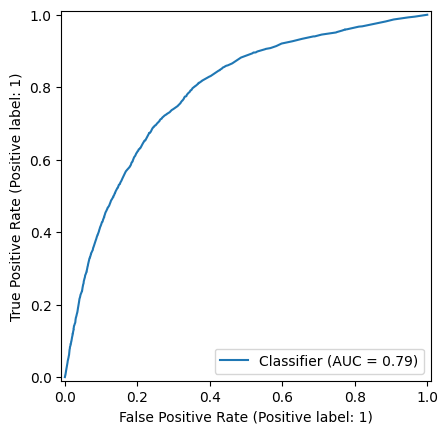

In [57]:
RocCurveDisplay.from_predictions(y_test, best_clf_rf.predict_proba(X_test_transformed)[:,1])

**Q7 (1 pt)** For the best model report the most relevant features, parameter `feature_importances_`

In [58]:
features_relevant = best_clf_rf.feature_importances_
names = X_train_transformed.columns
series = pd.Series(features_relevant, index=names).sort_values(ascending=False)
series

remainder__LengthOfStay       0.594299
remainder__AgeAtFirstClaim    0.146216
remainder__CharlsonIndex      0.093231
remainder__ClaimsTruncated    0.078431
OneHot__Sex_nan               0.074753
OneHot__Sex_M                 0.013070
dtype: float64

## Part 3.
**Q8 (5 pt)** Given the confusion matrix, write the expression that calculates macro- and micro- f1-score. For macro-averaging we calculate f1 for every class and then average. For micro-averaging we average TP, FP, FN and then calculate metrics.

**Write the code that calculates f1-score using the numbers below**

In [59]:
np.random.seed(42)
y_target = np.random.randint(0, 3, 20)
y_pred = np.random.randint(0, 3, 20)

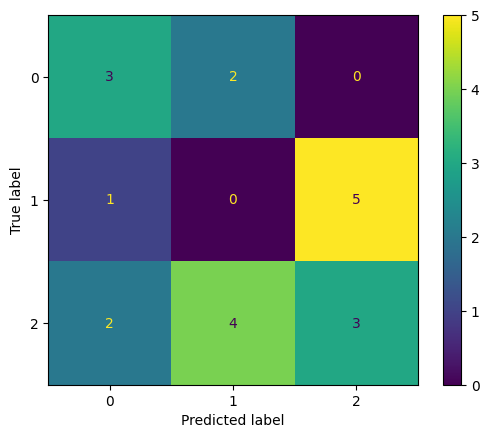

In [60]:
ConfusionMatrixDisplay.from_predictions(y_target, y_pred)

In [61]:
# Class 0: TP, FP, FN
TP_0 = 3
FP_0 = 1 + 2
FN_0 = 2 + 0

# Class 0: Precision and Recall
precision_0 = TP_0 / (TP_0 + FP_0)
recall_0 = TP_0 / (TP_0 + FN_0)

# Class 0: F1
F1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)

In [64]:
# Class 1: TP, FP, FN
TP_1 = 0
FP_1 = 2 + 4
FN_1 = 1 + 5

# Class 1: Precision and Recall
precision_1 = TP_1 / (TP_1 + FP_1)
recall_1 = TP_1 / (TP_1 + FN_1)

# Class 1: F1
# F1_1 = 0 * 2 * (precision_1 * recall_1) / (precision_1 + recall_1) # Division by zero
F1_1 = 0

In [65]:
# Class 2: TP, FP, FN
TP_2 = 3
FP_2 = 5 + 0
FN_2 = 2 + 4

# Class 2: Precision and Recall
precision_2 = TP_2 / (TP_2 + FP_2)
recall_2 = TP_2 / (TP_2 + FN_2)

# Class 2: F1
F1_2 = 2 * (precision_2 * recall_2) / (precision_2 + recall_2)

In [66]:
# Macro F1 is average of each class F1
f1_macro = (F1_0 + F1_1 + F1_2) / 3

In [67]:
from sklearn.metrics import make_scorer, f1_score

In [68]:
assert np.abs(f1_macro-f1_score(y_target, y_pred, average="macro")) < 1e-5

In [70]:
f1_macro

0.29946524064171126

In [71]:
f1_score(y_target, y_pred, average="macro")

0.29946524064171126

In [72]:
# Total TP, FP, and FN
TP_total = TP_0 + TP_1 + TP_2
FP_total = FP_0 + FP_1 + FP_2
FN_total = FN_0 + FN_1 + FN_2

# Total Precision and Recall
precision_micro = TP_total / (TP_total + FP_total)
recall_micro = TP_total / (TP_total + FN_total)

In [73]:
f1_micro = 2 * (precision_micro * recall_micro) / (precision_micro + recall_micro)

In [74]:
assert np.abs(f1_micro-f1_score(y_target, y_pred, average="micro")) < 1e-5

In [75]:
f1_micro

0.3

In [76]:
f1_score(y_target, y_pred, average="micro")

0.3